# $\text{Arrow Debreu European Option Solver}$

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import nnls, lsq_linear

In [3]:
ticker = '^SPX' #<-- may enter a differnt ticker
ticker_data = yf.Ticker(ticker)
expiry = ticker_data.options[4] #<-- the grater the index the longer until expiry
print(f'The following are the available expiration dates:\n\n{ticker_data.options}\n')
print('Using Expiry:', expiry)
chain = ticker_data.option_chain(expiry)
calls = chain.calls

The following are the available expiration dates:

('2025-07-10', '2025-07-11', '2025-07-14', '2025-07-15', '2025-07-16', '2025-07-17', '2025-07-18', '2025-07-21', '2025-07-22', '2025-07-23', '2025-07-24', '2025-07-25', '2025-07-28', '2025-07-29', '2025-07-30', '2025-07-31', '2025-08-01', '2025-08-04', '2025-08-05', '2025-08-06', '2025-08-07', '2025-08-08', '2025-08-11', '2025-08-12', '2025-08-15', '2025-08-22', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-17', '2025-10-31', '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31', '2026-01-16', '2026-02-20', '2026-03-20', '2026-03-31', '2026-04-17', '2026-05-15', '2026-06-18', '2026-06-30', '2026-07-17', '2026-09-18', '2026-12-18', '2027-06-17', '2027-12-17', '2028-12-15', '2029-12-21', '2030-12-20')

Using Expiry: 2025-07-16


In [15]:
#gets the latest spot and computes the states for payoff matrix columns
spot = ticker_data.history(period='1d')['Close'].iloc[-1]
possible_states = np.linspace( spot - 25, spot + 25, 5, dtype=int)
print('Using Spot:', spot, '\n')
print(f'Will be pricing options for the following spot prices: {possible_states} expiring on {expiry}')

Using Spot: 6280.4599609375 

Will be pricing options for the following spot prices: [6255 6267 6280 6292 6305] expiring on 2025-07-16


In [16]:
available_strikes = sorted(calls["strike"])
available_strikes = [int(i) for i in available_strikes]
for i in available_strikes:
    int(i)
print('Available Strikes:\n\n', available_strikes)

Available Strikes:

 [5600, 5625, 5700, 5750, 5790, 5825, 5850, 5860, 5870, 5880, 5890, 5900, 5910, 5920, 5925, 5930, 5940, 5950, 5960, 5970, 5975, 5980, 5990, 6000, 6010, 6015, 6020, 6025, 6030, 6035, 6040, 6050, 6060, 6065, 6070, 6075, 6080, 6085, 6090, 6095, 6100, 6110, 6115, 6120, 6125, 6130, 6135, 6140, 6145, 6150, 6155, 6160, 6165, 6170, 6175, 6180, 6185, 6190, 6195, 6200, 6205, 6210, 6215, 6220, 6225, 6230, 6235, 6240, 6245, 6250, 6255, 6260, 6265, 6270, 6275, 6280, 6285, 6290, 6295, 6300, 6305, 6310, 6320, 6325, 6330, 6335, 6340, 6345, 6350, 6360, 6370, 6375, 6380, 6390, 6400, 6410, 6425, 6450, 6475, 6500, 6525, 6550, 6575, 6600, 6700, 6800, 7000, 7200]


In [18]:
atm_index = min(range(len(available_strikes)), key=lambda i: abs(available_strikes[i] - spot))
lower_bound = max(atm_index -2, 0)
upper_bound = min(atm_index + 3, len(available_strikes))
chosen_strikes = available_strikes[lower_bound:upper_bound]
chosen_strikes = np.array(chosen_strikes)
print(f'Selected {len(chosen_strikes)} strikes around ATM:', '\n\n', chosen_strikes)

Selected 5 strikes around ATM: 

 [6270 6275 6280 6285 6290]


In [19]:
chosen_calls = calls[calls['strike'].isin(chosen_strikes)].copy().reset_index(drop=True)
chosen_calls = chosen_calls[['strike', 'lastPrice', 'bid', 'ask', "lastTradeDate", "openInterest"]]
chosen_calls

,strike,lastPrice,bid,ask,lastTradeDate,openInterest
0,6270.0,37.40,37.7,38.2,2025-07-10 19:02:11+00:00,447
1,6275.0,36.40,34.8,35.2,2025-07-10 20:00:07+00:00,1207
2,6280.0,33.63,32.0,32.4,2025-07-10 20:06:52+00:00,279
3,6285.0,30.99,29.3,29.8,2025-07-10 20:03:35+00:00,101
4,6290.0,28.45,26.8,27.2,2025-07-10 19:57:30+00:00,286


In [20]:
strikes = chosen_calls["strike"].values
price_vector = chosen_calls["lastPrice"].values
print(f'Strikes:\n\n{strikes}', f'\n\nPrices:\n\n {price_vector}')

Strikes:

[6270. 6275. 6280. 6285. 6290.] 

Prices:

 [37.4  36.4  33.63 30.99 28.45]


In [21]:
terminal_prices = strikes.copy()
call_payoff_matrix = np.maximum(possible_states - chosen_strikes[:, None], 0)
print(f'Call payoff matrix F:\n\n {call_payoff_matrix}')

Call payoff matrix F:

 [[ 0  0 10 22 35]
 [ 0  0  5 17 30]
 [ 0  0  0 12 25]
 [ 0  0  0  7 20]
 [ 0  0  0  2 15]]


In [22]:
#this cell is intendted to show that the call pyaoff matrix is indeed singular
try:
    inverted = np.linalg.inv(call_payoff_matrix)
    print("surprisngly non singular lol")
except Exception as e:
    print(f"The mtx is singular, {e}")

try:
    state_prices = np.linalg.solve(call_payoff_matrix, price_vector)
    print("surprisngly non singular")
except Exception as e:
    print(f"The mtx is singular, {e}")

The mtx is singular, Singular matrix
The mtx is singular, Singular matrix


In [23]:
state_prices = nnls(call_payoff_matrix, price_vector)
#normalized_state_prices = state_prices / np.sum(state_prices)
print(state_prices)

(array([0.        , 0.        , 0.        , 0.        , 1.27060741]), np.float64(13.256460870640204))


In [13]:
print(f'Normalized State Prices ~ probabilities:\n\n{state_prices}\n\n p.s. "np.linalg.lstsq" was resulting in some values being negative so I had to use "scipy.optimize.nnls" i.e non-negative least squares.')

Normalized State Prices ~ probabilities:

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.13354805]), np.float64(34.94791887975554))

 p.s. "np.linalg.lstsq" was resulting in some values being negative so I had to use "scipy.optimize.nnls" i.e non-negative least squares.


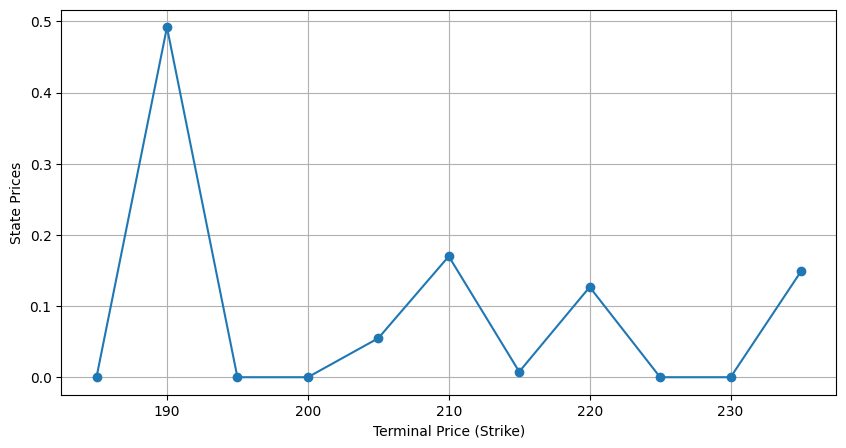

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(terminal_prices, normalized_state_prices, marker='o')
plt.xlabel('Terminal Price (Strike)')
plt.ylabel('State Prices')
plt.grid(True)
plt.show()

In [43]:
call_prices = call_payoff_matrix @ state_prices

call_prices = pd.DataFrame({
    'Strike': chosen_strikes,
    '$Call': call_prices
})
call_prices

,Strike,$Call
0,185,25.700000
1,190,20.345199
2,195,16.485274
3,200,12.625348
4,205,9.015447
5,210,6.346829
6,215,4.229756
7,220,2.713839
8,225,1.583073
9,230,0.452307


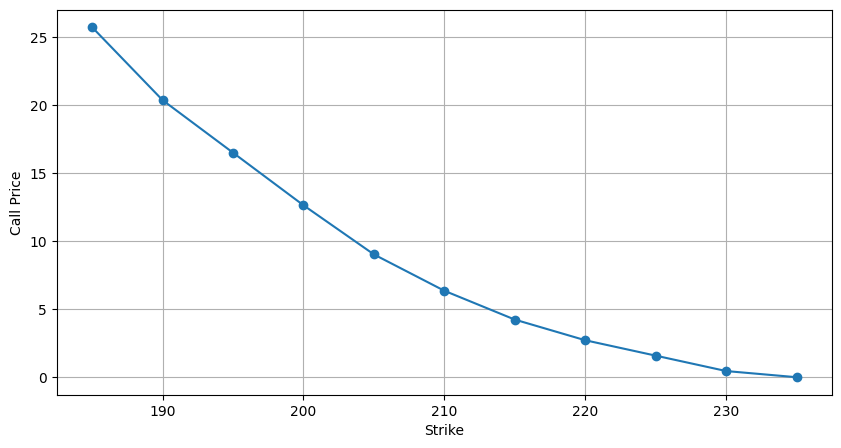

In [44]:
plt.figure(figsize=(10,5))
plt.plot(chosen_strikes, call_prices['$Call'], marker='o')
plt.xlabel('Strike')
plt.ylabel('Call Price')
plt.grid(True)
plt.show()

In [25]:
#below is the whole logic to price puts based on puts and turns out that nnls results in most of the values being zero and
# so I just solved for the state prices by inverting the payoff matrix and let all the negative values be zero.
puts = chain.puts
available_puts = sorted(puts["strike"])
available_puts = [int(i) for i in available_puts]
atm_put_index = min(range(len(available_puts)), key=lambda i: abs(available_puts[i] - spot))
lower_put_bound = max(atm_put_index -2, 0)
upper_put_bound = min(atm_put_index + 3, len(available_puts))
chosen_put_strikes = available_puts[lower_put_bound:upper_put_bound]
chosen_put_strikes = np.array(chosen_put_strikes)
chosen_puts = puts[puts['strike'].isin(chosen_put_strikes)].copy().reset_index(drop=True)
chosen_puts = chosen_puts[["strike", "lastPrice"]]
put_strikes = chosen_puts['strike'].values
put_price_vector = chosen_puts['lastPrice'].values
terminal_put_prices = put_strikes.copy()
put_payoff_matrix = np.maximum(chosen_put_strikes[:, None] - possible_states, 0)
print(put_payoff_matrix)

try:
    inverted_put = np.linalg.inv(put_payoff_matrix)
    print("\n\nsurprisngly non singular")
except Exception as e:
    print(f"The mtx is singular, {e}")

try:
    put_state_prices = np.linalg.solve(put_payoff_matrix, put_price_vector)
    print("surprisngly non singular")
except Exception as e:
    print(f"The mtx is singular, {e}")

put_state_prices = inverted_put @ put_price_vector
print(f"\n\nNote that the state prices are still neagtive regardless {put_state_prices}")

put_state_prices = [max(i, 0) for i in put_state_prices]

normalized_put_state_prices = put_state_prices / np.sum(put_state_prices)

plt.figure(figsize=(10, 5))
plt.plot(terminal_put_prices, normalized_put_state_prices, marker='o')
plt.xlabel('Terminal Price (Strike)')
plt.ylabel('Put State Prices')
plt.grid(True)
plt.show()

put_prices = put_payoff_matrix @ put_state_prices

put_prices = pd.DataFrame({
    'Strike': chosen_put_strikes,
    '$Put': put_prices
})
put_prices

plt.figure(figsize=(10,5))
plt.plot(chosen_put_strikes, put_prices['$Put'], marker='o')
plt.xlabel('Strike')
plt.ylabel('Call Price')
plt.grid(True)
plt.show()

[[15  3  0  0  0]
 [20  8  0  0  0]
 [25 13  0  0  0]
 [30 18  5  0  0]
 [35 23 10  0  0]]
The mtx is singular, Singular matrix
The mtx is singular, Singular matrix


NameError: name 'inverted_put' is not defined